# Лабораторная работа №6 (Проведение исследований с моделями классификации)

## 1. Выбор начальных условий

В качестве датасета для данной лаборатороной работы я выбрал классификацию [животных](https://www.kaggle.com/datasets/borhanitrash/animal-image-classification-dataset) на фотографии.

Обучение модели может помочь в видеонаблюдение, ведению определённых статистик связанных с животными


Используемые метрики Accuracy, Precision, Recall, F1 позволяют оценивать точность модели и количество ложных срабатываний.

Загрузка изображений из папок, преобразование и разбиение на train/val/test.

In [1]:
from torchvision import datasets, transforms
from torch.utils.data import random_split

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root='/kaggle/input/animal-image-classification-dataset/Animals', transform=transform)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


Импорт библиотек и определение устройства (GPU или CPU).

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights, vit_b_16, ViT_B_16_Weights
from sklearn.metrics import classification_report
import seaborn as sns
from copy import deepcopy


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Ограничение объёма выборки до 100 изображений, подготовка DataLoader’ов и получение имён классов.

In [3]:
# Количество картинок (None = брать все)
NUM_TRAIN_SAMPLES = 100
NUM_TEST_SAMPLES = 100
SIZE = 224

# Трансформации для данных
train_transforms = transforms.Compose([
    transforms.Resize((SIZE, SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)
])

test_transforms = transforms.Compose([
    transforms.Resize((SIZE, SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)
])
def get_subset(dataset, num_samples):
    if num_samples is None or num_samples >= len(dataset):
        return dataset
    indices = random.sample(range(len(dataset)), num_samples)
    
    return Subset(dataset, indices)

train_dataset = get_subset(train_dataset, NUM_TRAIN_SAMPLES)
test_dataset = get_subset(test_dataset, NUM_TEST_SAMPLES)

# Создание DataLoader'ов
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Получение названий классов (для отчётов и матрицы ошибок)
class_names = dataset.classes
print("Классы:", class_names)

Классы: ['cats', 'dogs', 'snakes']


Функция обучения модели с расчётом потерь и точности на тестовой выборке.

In [4]:
def train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs=3, is_print=True):
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        
        if is_print:
            print(f"Эпоха {epoch+1}/{num_epochs}, Потери: {epoch_loss:.4f}")

    # Просто проверка, что модель работает на тестовых данных
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total

    if is_print:
        print(f"Точность на тестовой выборке: {acc:.2f}")

# 2. Создание бейзлайна и оценка качества

Загрузка и адаптация ResNet18, обучение — точность 96%.

In [5]:
# Загружаем предобученную модель и адаптируем под число классов
weights = ResNet18_Weights.DEFAULT
resnet18 = resnet18(weights=weights)
resnet18.fc = nn.Linear(resnet18.fc.in_features, len(class_names))

# Настройка оптимизатора и функции потерь
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=1e-4)

# Обучение
train_model(resnet18, criterion, optimizer, train_loader, test_loader)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 31.2MB/s]


Эпоха 1/3, Потери: 0.8730
Эпоха 2/3, Потери: 0.1163
Эпоха 3/3, Потери: 0.0372
Точность на тестовой выборке: 0.96


Загрузка и обучение ViT, точность выше — 98%.

In [6]:
# Импорт модели ViT из torchvision
weights = ViT_B_16_Weights.DEFAULT
vit = vit_b_16(weights=weights)
vit.heads.head = nn.Linear(vit.heads.head.in_features, len(class_names))

# Настройка оптимизатора и функции потерь
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit.parameters(), lr=1e-4)

# Обучение
train_model(vit, criterion, optimizer, train_loader, test_loader)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:10<00:00, 32.2MB/s] 


Эпоха 1/3, Потери: 0.9907
Эпоха 2/3, Потери: 0.1893
Эпоха 3/3, Потери: 0.0264
Точность на тестовой выборке: 0.98


Функция для оценки модели: предсказания на тестовой выборке и расчёт метрик через classification_report.

In [7]:
def evaluate_model(model, dataloader, class_names):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    label_ids = list(range(len(class_names)))
    report = classification_report(
        y_true,
        y_pred,
        labels=label_ids,
        target_names=class_names,
        zero_division=0,
        output_dict=True
    )
    
    return report

Оценка ResNet18: точность 96%, все метрики около 0.96.

In [8]:
report_resnet = evaluate_model(resnet18, test_loader, class_names)

# Извлекаем нужные метрики
accuracy_resnet = report_resnet["accuracy"]
precision_resnet = report_resnet["macro avg"]["precision"]
recall_resnet = report_resnet["macro avg"]["recall"]
f1_resnet = report_resnet["macro avg"]["f1-score"]
weighted_resnet = report_resnet["weighted avg"]["f1-score"]

print(f"ResNet18 Accuracy: {accuracy_resnet:.4f}")
print(f"Precision: {precision_resnet:.4f}, Recall: {recall_resnet:.4f}, F1: {f1_resnet:.4f}")
print(f"Weighted avg: {weighted_resnet:.4f}")

ResNet18 Accuracy: 0.9600
Precision: 0.9614, Recall: 0.9610, F1: 0.9610
Weighted avg: 0.9602


Оценка ViT: точность 98%, метрики выше, чем у ResNet18.

In [9]:
report_vit = evaluate_model(vit, test_loader, class_names)

# Извлекаем нужные метрики
accuracy_vit = report_vit["accuracy"]
precision_vit = report_vit["macro avg"]["precision"]
recall_vit = report_vit["macro avg"]["recall"]
f1_vit = report_vit["macro avg"]["f1-score"]
weighted_vit = report_vit["weighted avg"]["f1-score"]

print(f"ViT Accuracy: {accuracy_vit:.4f}")
print(f"Precision: {precision_vit:.4f}, Recall: {recall_vit:.4f}, F1: {f1_vit:.4f}")
print(f"Weighted avg: {weighted_vit:.4f}")

ViT Accuracy: 0.9800
Precision: 0.9806, Recall: 0.9781, F1: 0.9792
Weighted avg: 0.9800


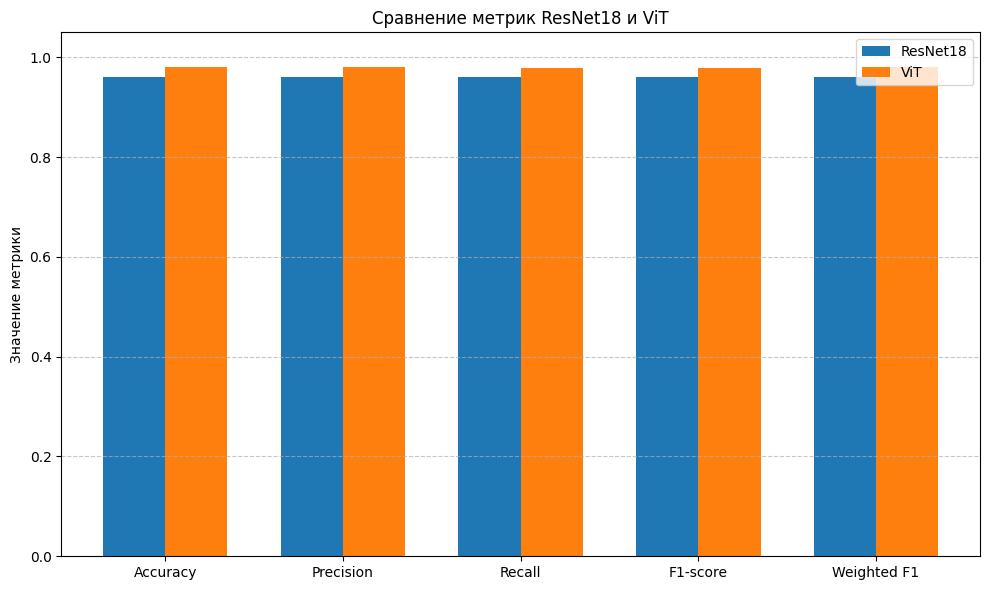

In [10]:
metrics = ["Accuracy", "Precision", "Recall", "F1-score", "Weighted F1"]
resnet_scores = [accuracy_resnet, precision_resnet, recall_resnet, f1_resnet, weighted_resnet]
vit_scores = [accuracy_vit, precision_vit, recall_vit, f1_vit, weighted_vit]

x = np.arange(len(metrics))
width = 0.35

# Построение графика
plt.figure(figsize=(10, 6))
plt.bar(x - width / 2, resnet_scores, width, label="ResNet18")
plt.bar(x + width / 2, vit_scores, width, label="ViT")

plt.ylabel("Значение метрики")
plt.title("Сравнение метрик ResNet18 и ViT")
plt.xticks(x, metrics)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3. Улучшение бейзлайна

Эпоха 1/3, Потери: 0.8136
Эпоха 2/3, Потери: 0.2510
Эпоха 3/3, Потери: 0.2029
Точность на тестовой выборке: 0.90
Эпоха 1/3, Потери: 0.4567
Эпоха 2/3, Потери: 0.0914
Эпоха 3/3, Потери: 0.0259
Точность на тестовой выборке: 0.93
ResNet18 (аугмент.):
Accuracy: 0.9000
Precision: 0.9090, Recall: 0.9094, F1: 0.9044
Weighted avg: 0.8986
ViT (аугмент.):
Accuracy: 0.9300
Precision: 0.9387, Recall: 0.9334, F1: 0.9345
Weighted avg: 0.9300


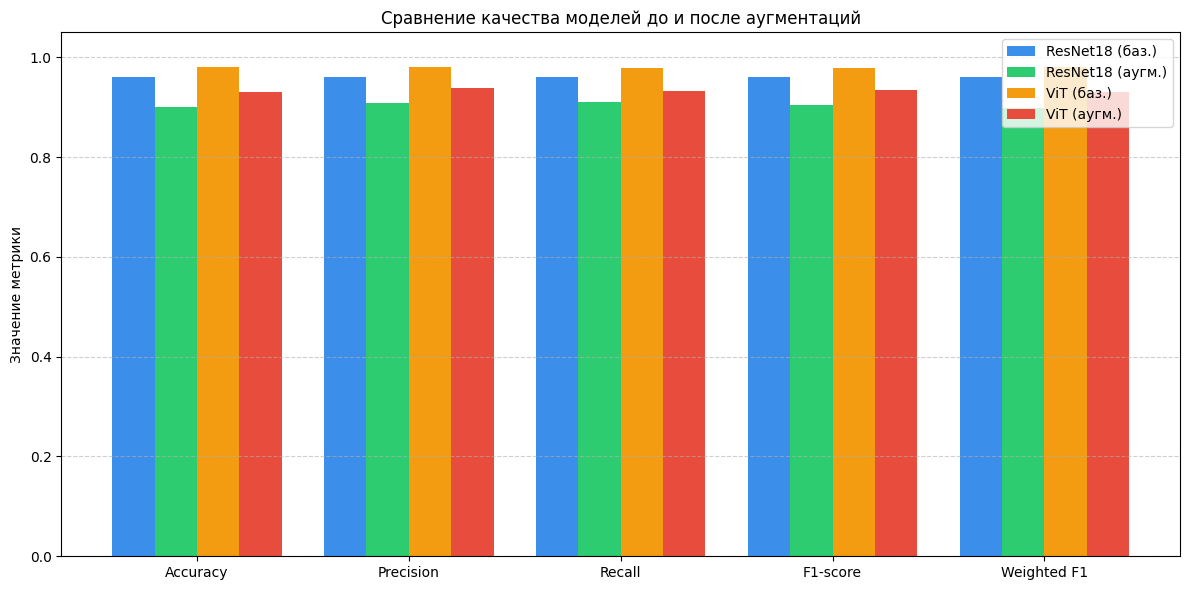

In [18]:
from torch.utils.data import Dataset
# Загружаем все изображения из корневой папки
dataset = datasets.ImageFolder(root='/kaggle/input/animal-image-classification-dataset/Animals')

# Размеры выборок
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Разделение
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


from torchvision.models import resnet18, ResNet18_Weights

class TransformedDataset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

# Аугментированный train-трансформ
augmented_train_transforms = transforms.Compose([
    transforms.Resize((SIZE, SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)
])

# Тестовый трансформ
test_transforms = transforms.Compose([
    transforms.Resize((SIZE, SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)
])

train_dataset = TransformedDataset(train_dataset, augmented_train_transforms)
test_dataset = TransformedDataset(test_dataset, test_transforms)


train_indices = random.sample(range(len(train_dataset)), NUM_TRAIN_SAMPLES)
test_indices = random.sample(range(len(test_dataset)), NUM_TEST_SAMPLES)

aug_train_dataset_small = Subset(train_dataset, train_indices)
test_dataset_small = Subset(test_dataset, test_indices)

aug_train_loader = DataLoader(aug_train_dataset_small, batch_size=4, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset_small, batch_size=4, shuffle=False)

weights = ResNet18_Weights.DEFAULT
resnet_aug = resnet18(weights=weights)
resnet_aug.fc = nn.Linear(resnet_aug.fc.in_features, len(class_names))

resnet_aug = resnet_aug.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_aug.parameters(), lr=1e-4)

train_model(resnet_aug, criterion, optimizer, aug_train_loader, test_loader)

weights = ViT_B_16_Weights.DEFAULT
vit_aug = vit_b_16(weights=weights)
vit_aug.heads.head = nn.Linear(vit_aug.heads.head.in_features, len(class_names))

vit_aug = vit_aug.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_aug.parameters(), lr=1e-4)

train_model(vit_aug, criterion, optimizer, aug_train_loader, test_loader)

report_resnet_aug = evaluate_model(resnet_aug, test_loader, class_names)

accuracy_resnet_aug = report_resnet_aug["accuracy"]
precision_resnet_aug = report_resnet_aug["macro avg"]["precision"]
recall_resnet_aug = report_resnet_aug["macro avg"]["recall"]
f1_resnet_aug = report_resnet_aug["macro avg"]["f1-score"]
weighted_resnet_aug = report_resnet_aug["weighted avg"]["f1-score"]

print("ResNet18 (аугмент.):")
print(f"Accuracy: {accuracy_resnet_aug:.4f}")
print(f"Precision: {precision_resnet_aug:.4f}, Recall: {recall_resnet_aug:.4f}, F1: {f1_resnet_aug:.4f}")
print(f"Weighted avg: {weighted_resnet_aug:.4f}")

report_vit_aug = evaluate_model(vit_aug, test_loader, class_names)

accuracy_vit_aug = report_vit_aug["accuracy"]
precision_vit_aug = report_vit_aug["macro avg"]["precision"]
recall_vit_aug = report_vit_aug["macro avg"]["recall"]
f1_vit_aug = report_vit_aug["macro avg"]["f1-score"]
weighted_vit_aug = report_vit_aug["weighted avg"]["f1-score"]

print("ViT (аугмент.):")
print(f"Accuracy: {accuracy_vit_aug:.4f}")
print(f"Precision: {precision_vit_aug:.4f}, Recall: {recall_vit_aug:.4f}, F1: {f1_vit_aug:.4f}")
print(f"Weighted avg: {weighted_vit_aug:.4f}")

# Метрики, которые будем сравнивать
metrics = ["Accuracy", "Precision", "Recall", "F1-score", "Weighted F1"]

resnet_vals = [accuracy_resnet, precision_resnet, recall_resnet, f1_resnet, weighted_resnet]
resnet_aug_vals = [accuracy_resnet_aug, precision_resnet_aug, recall_resnet_aug, f1_resnet_aug, weighted_resnet_aug]

vit_vals = [accuracy_vit, precision_vit, recall_vit, f1_vit, weighted_vit]
vit_aug_vals = [accuracy_vit_aug, precision_vit_aug, recall_vit_aug, f1_vit_aug, weighted_vit_aug]

x = np.arange(len(metrics))
width = 0.2

# Построение графика
plt.figure(figsize=(12, 6))
plt.bar(x - 1.5 * width, resnet_vals, width, label="ResNet18 (баз.)", color="#3b8eea")
plt.bar(x - 0.5 * width, resnet_aug_vals, width, label="ResNet18 (аугм.)", color="#2ecc71")
plt.bar(x + 0.5 * width, vit_vals, width, label="ViT (баз.)", color="#f39c12")
plt.bar(x + 1.5 * width, vit_aug_vals, width, label="ViT (аугм.)", color="#e74c3c")

# Подписи
plt.ylabel("Значение метрики")
plt.title("Сравнение качества моделей до и после аугментаций")
plt.xticks(x, metrics)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

ResNet18 | Тест: LR=0.001, Batch=4, Epochs=3
ResNet18 | Тест: LR=0.001, Batch=4, Epochs=4
ResNet18 | Тест: LR=0.001, Batch=8, Epochs=3
ResNet18 | Тест: LR=0.001, Batch=8, Epochs=4
ResNet18 | Тест: LR=0.0001, Batch=4, Epochs=3
ResNet18 | Тест: LR=0.0001, Batch=4, Epochs=4
ResNet18 | Тест: LR=0.0001, Batch=8, Epochs=3
ResNet18 | Тест: LR=0.0001, Batch=8, Epochs=4
ViT | Тест: LR=0.001, Batch=4, Epochs=3
ViT | Тест: LR=0.001, Batch=4, Epochs=4
ViT | Тест: LR=0.001, Batch=8, Epochs=3
ViT | Тест: LR=0.001, Batch=8, Epochs=4
ViT | Тест: LR=0.0001, Batch=4, Epochs=3
ViT | Тест: LR=0.0001, Batch=4, Epochs=4
ViT | Тест: LR=0.0001, Batch=8, Epochs=3
ViT | Тест: LR=0.0001, Batch=8, Epochs=4

Лучшие гиперпараметры: ResNet18
LR: 0.0001, Batch: 4, Epochs: 4, F1: 0.9594

Лучшие гиперпараметры: ViT
LR: 0.0001, Batch: 8, Epochs: 4, F1: 0.9687


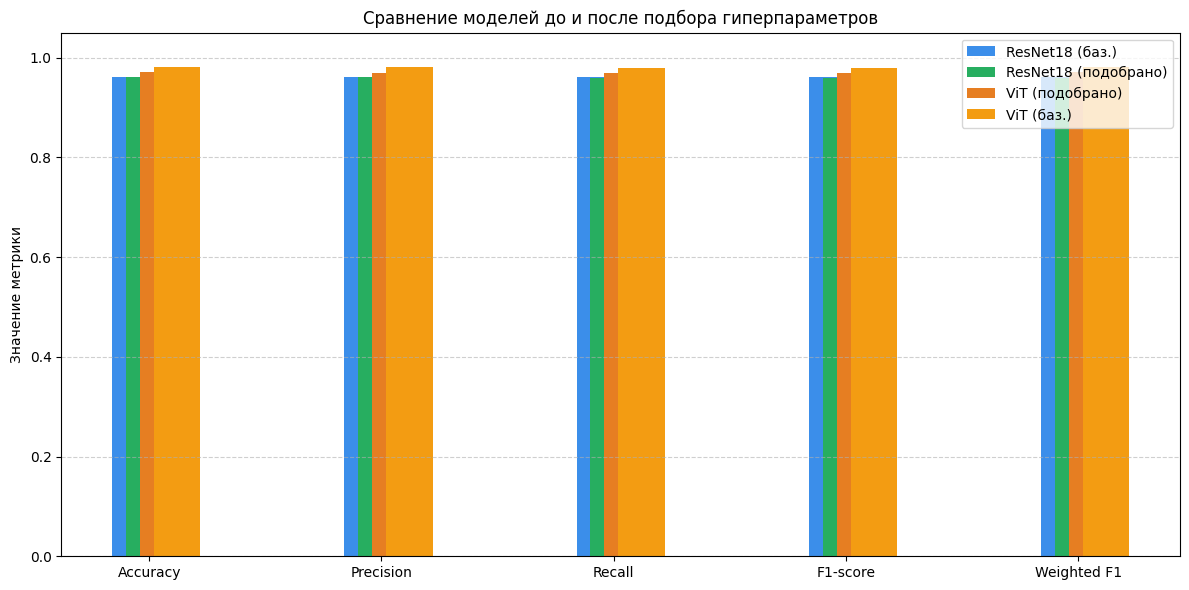

In [19]:
from torch.utils.data import Dataset
# Загружаем все изображения из корневой папки
dataset = datasets.ImageFolder(root='/kaggle/input/animal-image-classification-dataset/Animals')

# Размеры выборок
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Разделение
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

class TransformedDataset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)


lr_options = [1e-3, 1e-4]
batch_options = [4, 8]
epoch_options = [3, 4]

simple_transforms = transforms.Compose([
    transforms.Resize((SIZE, SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)
])

train_dataset = TransformedDataset(train_dataset, simple_transforms)
test_dataset = TransformedDataset(test_dataset, simple_transforms)


train_indices = random.sample(range(len(train_dataset)), NUM_TRAIN_SAMPLES)
test_indices = random.sample(range(len(test_dataset)), NUM_TEST_SAMPLES)

train_dataset_hp = Subset(train_dataset, train_indices)
test_dataset_hp = Subset(test_dataset, test_indices)
            
results_resnet = []
results_vit = []

for lr in lr_options:
    for batch in batch_options:
        for epochs in epoch_options:
            print(f"ResNet18 | Тест: LR={lr}, Batch={batch}, Epochs={epochs}")

            train_loader_hp = DataLoader(train_dataset_hp, batch_size=batch, shuffle=True, num_workers=0)
            test_loader_hp = DataLoader(test_dataset_hp, batch_size=batch, shuffle=False)

            model_r = resnet18(weights=ResNet18_Weights.DEFAULT)
            model_r.fc = nn.Linear(model_r.fc.in_features, len(class_names))
            model_r = model_r.to(device)

            optimizer_r = optim.Adam(model_r.parameters(), lr=lr)
            criterion_r = nn.CrossEntropyLoss()

            train_model(model_r, criterion_r, optimizer_r, train_loader_hp, test_loader_hp, num_epochs=epochs, is_print=False)
            report_r = evaluate_model(model_r, test_loader_hp, class_names)

            results_resnet.append({
                "lr": lr, "batch": batch, "epochs": epochs,
                "f1": report_r["macro avg"]["f1-score"],
                "acc": report_r["accuracy"],
                "report": deepcopy(report_r)
            })

for lr in lr_options:
    for batch in batch_options:
        for epochs in epoch_options:
            print(f"ViT | Тест: LR={lr}, Batch={batch}, Epochs={epochs}")

            train_loader_hp = DataLoader(train_dataset_hp, batch_size=batch, shuffle=True, num_workers=0)
            test_loader_hp = DataLoader(test_dataset_hp, batch_size=batch, shuffle=False)

            model_v = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)
            model_v.heads.head = nn.Linear(model_v.heads.head.in_features, len(class_names))
            model_v = model_v.to(device)

            optimizer_v = optim.Adam(model_v.parameters(), lr=lr)
            criterion_v = nn.CrossEntropyLoss()

            train_model(model_v, criterion_v, optimizer_v, train_loader_hp, test_loader_hp, num_epochs=epochs, is_print=False)
            report_v = evaluate_model(model_v, test_loader_hp, class_names)

            results_vit.append({
                "lr": lr, "batch": batch, "epochs": epochs,
                "f1": report_v["macro avg"]["f1-score"],
                "acc": report_v["accuracy"],
                "report": deepcopy(report_v)
            })

best_resnet = max(results_resnet, key=lambda x: x["f1"])
best_vit = max(results_vit, key=lambda x: x["f1"])

print("\nЛучшие гиперпараметры: ResNet18")
print(f"LR: {best_resnet['lr']}, Batch: {best_resnet['batch']}, Epochs: {best_resnet['epochs']}, F1: {best_resnet['f1']:.4f}")

print("\nЛучшие гиперпараметры: ViT")
print(f"LR: {best_vit['lr']}, Batch: {best_vit['batch']}, Epochs: {best_vit['epochs']}, F1: {best_vit['f1']:.4f}")

# Графики
metrics = ["Accuracy", "Precision", "Recall", "F1-score", "Weighted F1"]
x = np.arange(len(metrics))
width = 0.2

resnet_best_vals = [
    best_resnet["report"]["accuracy"],
    best_resnet["report"]["macro avg"]["precision"],
    best_resnet["report"]["macro avg"]["recall"],
    best_resnet["report"]["macro avg"]["f1-score"],
    best_resnet["report"]["weighted avg"]["f1-score"]
]

vit_best_vals = [
    best_vit["report"]["accuracy"],
    best_vit["report"]["macro avg"]["precision"],
    best_vit["report"]["macro avg"]["recall"],
    best_vit["report"]["macro avg"]["f1-score"],
    best_vit["report"]["weighted avg"]["f1-score"]
]

plt.figure(figsize=(12, 6))
plt.bar(x - 0.3 * width, resnet_vals, width, label="ResNet18 (баз.)", color="#3b8eea")
plt.bar(x, resnet_best_vals, width, label="ResNet18 (подобрано)", color="#27ae60")
plt.bar(x + 0.3 * width, vit_best_vals, width, label="ViT (подобрано)", color="#e67e22")
plt.bar(x + 0.6 * width, vit_vals, width, label="ViT (баз.)", color="#f39c12")

plt.ylabel("Значение метрики")
plt.title("Сравнение моделей до и после подбора гиперпараметров")
plt.xticks(x, metrics)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 98.6MB/s]


Эпоха 1/3, Потери: 1.0438
Эпоха 2/3, Потери: 0.7325
Эпоха 3/3, Потери: 0.5161
Точность на тестовой выборке: 0.90


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 147MB/s]


Эпоха 1/3, Потери: 1.0128
Эпоха 2/3, Потери: 0.7222
Эпоха 3/3, Потери: 0.4971
Точность на тестовой выборке: 0.93


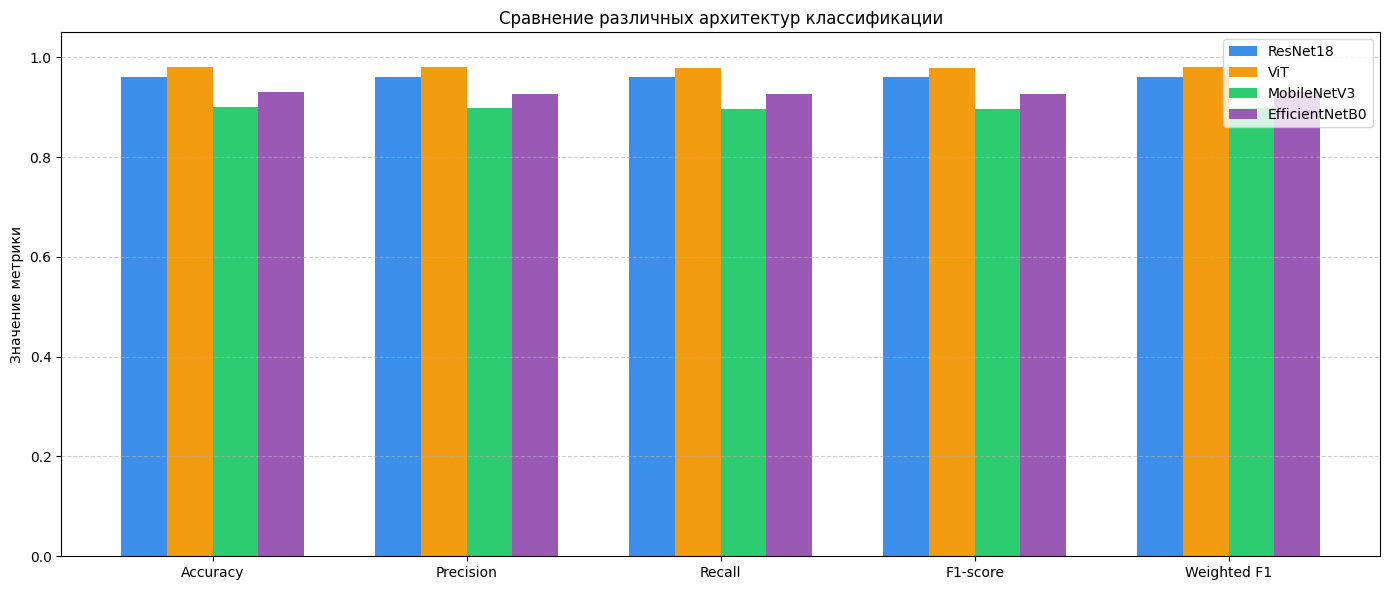

In [20]:
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights


# MobileNetV3
model_mobile = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
model_mobile.classifier[3] = nn.Linear(model_mobile.classifier[3].in_features, len(class_names))
model_mobile = model_mobile.to(device)

optimizer_mobile = optim.Adam(model_mobile.parameters(), lr=1e-4)
criterion_mobile = nn.CrossEntropyLoss()

train_model(model_mobile, criterion_mobile, optimizer_mobile, train_loader_hp, test_loader_hp, num_epochs=3)

report_mobile = evaluate_model(model_mobile, test_loader_hp, class_names)

# Извлекаем метрики
accuracy_mobile = report_mobile["accuracy"]
precision_mobile = report_mobile["macro avg"]["precision"]
recall_mobile = report_mobile["macro avg"]["recall"]
f1_mobile = report_mobile["macro avg"]["f1-score"]
weighted_mobile = report_mobile["weighted avg"]["f1-score"]

# EfficientNetB0
model_effnet = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
model_effnet.classifier[1] = nn.Linear(model_effnet.classifier[1].in_features, len(class_names))
model_effnet = model_effnet.to(device)

optimizer_eff = optim.Adam(model_effnet.parameters(), lr=1e-4)
criterion_eff = nn.CrossEntropyLoss()

train_model(model_effnet, criterion_eff, optimizer_eff, train_loader_hp, test_loader_hp, num_epochs=3)

report_eff = evaluate_model(model_effnet, test_loader_hp, class_names)

# Извлекаем метрики
accuracy_eff = report_eff["accuracy"]
precision_eff = report_eff["macro avg"]["precision"]
recall_eff = report_eff["macro avg"]["recall"]
f1_eff = report_eff["macro avg"]["f1-score"]
weighted_eff = report_eff["weighted avg"]["f1-score"]

metrics = ["Accuracy", "Precision", "Recall", "F1-score", "Weighted F1"]
x = np.arange(len(metrics))
width = 0.18

mobilenet_vals = [accuracy_mobile, precision_mobile, recall_mobile, f1_mobile, weighted_mobile]
effnet_vals = [accuracy_eff, precision_eff, recall_eff, f1_eff, weighted_eff]

plt.figure(figsize=(14, 6))
plt.bar(x - 1.5 * width, resnet_vals, width, label="ResNet18", color="#3b8eea")
plt.bar(x - 0.5 * width, vit_vals, width, label="ViT", color="#f39c12")
plt.bar(x + 0.5 * width, mobilenet_vals, width, label="MobileNetV3", color="#2ecc71")
plt.bar(x + 1.5 * width, effnet_vals, width, label="EfficientNetB0", color="#9b59b6")

plt.ylabel("Значение метрики")
plt.title("Сравнение различных архитектур классификации")
plt.xticks(x, metrics)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [22]:
from torch.utils.data import Dataset
# Загружаем все изображения из корневой папки
dataset = datasets.ImageFolder(root='/kaggle/input/animal-image-classification-dataset/Animals')

# Размеры выборок
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Разделение
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

class TransformedDataset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)





train_best_transform = transforms.Compose([
    transforms.Resize((SIZE, SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)
])

train_dataset = TransformedDataset(train_dataset, train_best_transform)
test_dataset = TransformedDataset(test_dataset, train_best_transform)

resnet_train = Subset(train_dataset, random.sample(range(len(train_dataset)), NUM_TRAIN_SAMPLES))
vit_train = Subset(train_dataset, random.sample(range(len(train_dataset)), NUM_TRAIN_SAMPLES))
test_set = Subset(test_dataset, random.sample(range(len(test_dataset)), NUM_TEST_SAMPLES))

resnet_best_train_loader = DataLoader(resnet_train, batch_size=4, shuffle=True)
vit_best_train_loader = DataLoader(vit_train, batch_size=4, shuffle=True)
test_best_loader = DataLoader(test_set, batch_size=4, shuffle=False)

In [23]:
weights = ResNet18_Weights.DEFAULT
resnet_model = resnet18(weights=weights)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, len(class_names))
resnet_model = resnet_model.to(device)

optimizer_res = optim.Adam(resnet_model.parameters(), lr=1e-4)
criterion_res = nn.CrossEntropyLoss()

train_model(resnet_model, criterion_res, optimizer_res, resnet_best_train_loader, test_best_loader, num_epochs=4)
report_best_resnet = evaluate_model(resnet_model, test_loader, class_names)

# Метрики
accuracy_best_resnet = report_best_resnet["accuracy"]
precision_best_resnet = report_best_resnet["macro avg"]["precision"]
recall_best_resnet = report_best_resnet["macro avg"]["recall"]
f1_best_resnet = report_best_resnet["macro avg"]["f1-score"]
weighted_best_resnet = report_best_resnet["weighted avg"]["f1-score"]

Эпоха 1/4, Потери: 0.7062
Эпоха 2/4, Потери: 0.2515
Эпоха 3/4, Потери: 0.3096
Эпоха 4/4, Потери: 0.3128
Точность на тестовой выборке: 0.97


In [24]:
vit_model = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)
vit_model.heads.head = nn.Linear(vit_model.heads.head.in_features, len(class_names))
vit_model = vit_model.to(device)

optimizer_vit = optim.Adam(vit_model.parameters(), lr=1e-4)
criterion_vit = nn.CrossEntropyLoss()

train_model(vit_model, criterion_vit, optimizer_vit, vit_best_train_loader, test_best_loader, num_epochs=4)
report_best_vit = evaluate_model(vit_model, test_loader, class_names)

# Метрики
accuracy_best_vit = report_best_vit["accuracy"]
precision_best_vit = report_best_vit["macro avg"]["precision"]
recall_best_vit = report_best_vit["macro avg"]["recall"]
f1_best_vit = report_best_vit["macro avg"]["f1-score"]
weighted_best_vit = report_best_vit["weighted avg"]["f1-score"]

Эпоха 1/4, Потери: 0.5728
Эпоха 2/4, Потери: 0.0558
Эпоха 3/4, Потери: 0.0252
Эпоха 4/4, Потери: 0.2188
Точность на тестовой выборке: 0.87


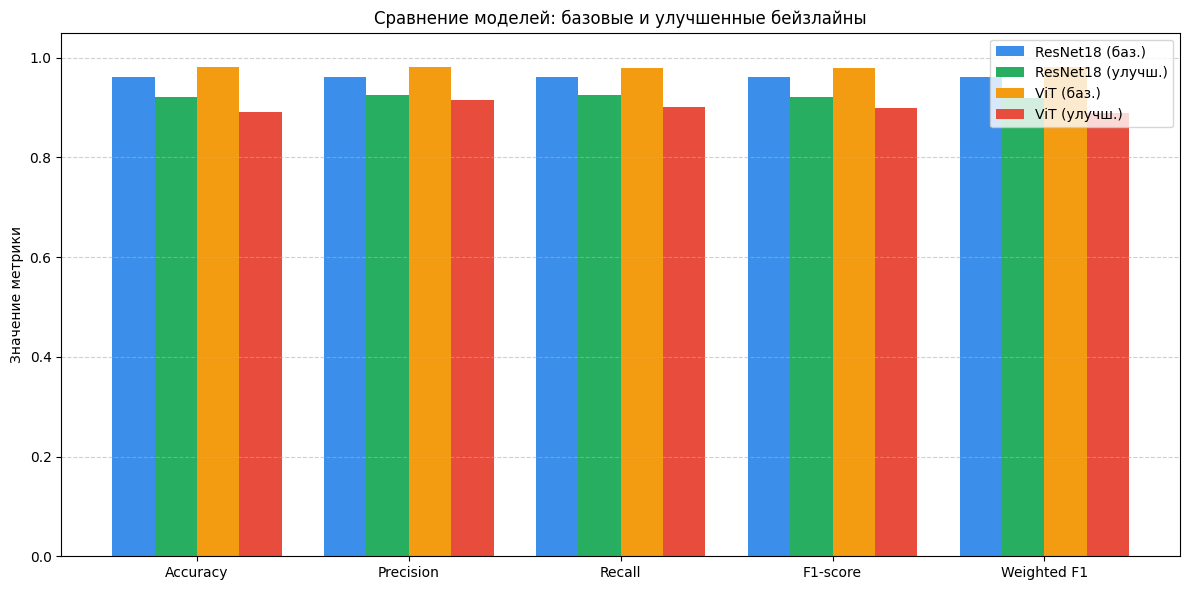

In [26]:
# Метрики для графика
metrics = ["Accuracy", "Precision", "Recall", "F1-score", "Weighted F1"]
resnet_old = [accuracy_resnet, precision_resnet, recall_resnet, f1_resnet, weighted_resnet]
resnet_new = [accuracy_best_resnet, precision_best_resnet, recall_best_resnet, f1_best_resnet, weighted_best_resnet]
vit_old = [accuracy_vit, precision_vit, recall_vit, f1_vit, weighted_vit]
vit_new = [accuracy_best_vit, precision_best_vit, recall_best_vit, f1_best_vit, weighted_best_vit]

x = np.arange(len(metrics))
width = 0.2

plt.figure(figsize=(12, 6))
plt.bar(x - 1.5 * width, resnet_old, width, label="ResNet18 (баз.)", color="#3b8eea")
plt.bar(x - 0.5 * width, resnet_new, width, label="ResNet18 (улучш.)", color="#27ae60")
plt.bar(x + 0.5 * width, vit_old, width, label="ViT (баз.)", color="#f39c12")
plt.bar(x + 1.5 * width, vit_new, width, label="ViT (улучш.)", color="#e74c3c")

plt.ylabel("Значение метрики")
plt.title("Сравнение моделей: базовые и улучшенные бейзлайны")
plt.xticks(x, metrics)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 4.	Имплементация алгоритма машинного обучения

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes * self.expansion, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(planes * self.expansion)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)

        return out
    
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        
        # Преобразуем изображение в патчи с помощью свёрточного слоя
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size,
                              stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim=768, num_heads=8, mlp_ratio=4.0, dropout=0.1):
        super(TransformerEncoderBlock, self).__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads,
                                          dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(embed_dim * mlp_ratio), embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # x: [B, N, embed_dim]
        attn_output, _ = self.attn(self.norm1(x), self.norm1(x), self.norm1(x))
        x = x + attn_output
        x = x + self.mlp(self.norm2(x))
        return x

In [3]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        
        # Начальный слой
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Последовательность блоков
        self.layer1 = self._make_layer(block, 64,  num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x
    
def custom_resnet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

In [4]:
class ViT(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, num_classes=10,
                 embed_dim=768, depth=12, num_heads=12, mlp_ratio=4.0, dropout=0.1):
        super(ViT, self).__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = self.patch_embed.num_patches
        
        # Классификационный токен
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        # Позиционные эмбеддинги
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        
        # Последовательность энкодер-блоков
        self.blocks = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        
        self._init_weights()

    def _init_weights(self):
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.head.weight, std=0.02)
        if self.head.bias is not None:
            nn.init.zeros_(self.head.bias)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)  # [B, num_patches, embed_dim]
        
        # Добавляем классификационный токен
        cls_tokens = self.cls_token.expand(B, -1, -1)  # [B, 1, embed_dim]
        x = torch.cat((cls_tokens, x), dim=1)            # [B, 1+num_patches, embed_dim]
        
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        for block in self.blocks:
            x = block(x)
            
        x = self.norm(x)
        cls_output = x[:, 0]  # Используем выход токена [CLS]
        x = self.head(cls_output)
        return x

def custom_vit_b_16(num_classes=10, img_size=224):
    return ViT(img_size=img_size, patch_size=16, in_channels=3, num_classes=num_classes,
               embed_dim=768, depth=12, num_heads=12, mlp_ratio=4.0, dropout=0.1)

In [11]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import random_split
# Загружаем все изображения из корневой папки
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = datasets.ImageFolder(root='/kaggle/input/animal-image-classification-dataset/Animals')
def train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs=3, is_print=True):
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        
        if is_print:
            print(f"Эпоха {epoch+1}/{num_epochs}, Потери: {epoch_loss:.4f}")

    # Просто проверка, что модель работает на тестовых данных
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total

    if is_print:
        print(f"Точность на тестовой выборке: {acc:.2f}")
# Размеры выборок
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Разделение
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

custom_resnet_model = custom_resnet18(num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_resnet_model.parameters(), lr=1e-4)

train_model(custom_resnet_model, criterion, optimizer, train_loader, test_loader)

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>

In [ ]:
# ResNet
report_custom_resnet = evaluate_model(resnet_model, test_loader, class_names)

accuracy_custom_resnet = report_custom_resnet["accuracy"]
precision_custom_resnet = report_custom_resnet["macro avg"]["precision"]
recall_custom_resnet = report_custom_resnet["macro avg"]["recall"]
f1_custom_resnet = report_custom_resnet["macro avg"]["f1-score"]
weighted_custom_resnet = report_custom_resnet["weighted avg"]["f1-score"]

print(f"ResNet18 Accuracy: {accuracy_custom_resnet:.4f}")
print(f"Precision: {precision_custom_resnet:.4f}, Recall: {recall_custom_resnet:.4f}, F1: {f1_custom_resnet:.4f}")
print(f"MWeighted avg: {weighted_custom_resnet:.4f}")

# ViT
report_custom_vit = evaluate_model(vit_model, test_loader, class_names)

# Извлекаем нужные метрики
accuracy_custom_vit = report_custom_vit["accuracy"]
precision_custom_vit = report_custom_vit["macro avg"]["precision"]
recall_custom_vit = report_custom_vit["macro avg"]["recall"]
f1_custom_vit = report_custom_vit["macro avg"]["f1-score"]
weighted_custom_vit = report_custom_vit["weighted avg"]["f1-score"]

print(f"ViT Accuracy: {accuracy_custom_vit:.4f}")
print(f"Precision: {precision_custom_vit:.4f}, Recall: {recall_custom_vit:.4f}, F1: {f1_custom_vit:.4f}")
print(f"Weighted avg: {weighted_custom_vit:.4f}")

In [ ]:
# Метрики для графика
metrics = ["Accuracy", "Precision", "Recall", "F1-score", "Weighted F1"]
resnet_old = [accuracy_resnet, precision_resnet, recall_resnet, f1_resnet, weighted_resnet]
resnet_new = [accuracy_custom_resnet, precision_custom_resnet, recall_custom_resnet, f1_custom_resnet, weighted_custom_resnet]
vit_old = [accuracy_vit, precision_vit, recall_vit, f1_vit, weighted_vit]
vit_new = [accuracy_custom_vit, precision_custom_vit, recall_custom_vit, f1_custom_vit, weighted_custom_vit]

x = np.arange(len(metrics))
width = 0.2

plt.figure(figsize=(12, 6))
plt.bar(x - 1.5 * width, resnet_old, width, label="ResNet18 (баз.)", color="#3b8eea")
plt.bar(x - 0.5 * width, resnet_new, width, label="ResNet18 (имп.)", color="#27ae60")
plt.bar(x + 0.5 * width, vit_old, width, label="ViT (баз.)", color="#f39c12")
plt.bar(x + 1.5 * width, vit_new, width, label="ViT (имп.)", color="#e74c3c")

plt.ylabel("Значение метрики")
plt.title("Сравнение моделей: базовые и имплементированные модели")
plt.xticks(x, metrics)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
custom_resnet_model = custom_resnet18(num_classes=len(class_names))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_resnet_model.parameters(), lr=1e-3)


train_model(resnet_model, criterion_res, optimizer_res, resnet_best_train_loader, test_best_loader, num_epochs=4)

In [ ]:
custom_vit_model = custom_vit_b_16(num_classes=len(class_names))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_vit_model.parameters(), lr=1e-4)

train_model(vit_model, criterion_vit, optimizer_vit, vit_best_train_loader, test_best_loader, num_epochs=3)

In [ ]:
# ResNet
report_custom_best_resnet = evaluate_model(resnet_model, test_loader, class_names)

accuracy_custom_best_resnet = report_custom_best_resnet["accuracy"]
precision_custom_best_resnet = report_custom_best_resnet["macro avg"]["precision"]
recall_custom_best_resnet = report_custom_best_resnet["macro avg"]["recall"]
f1_custom_best_resnet = report_custom_best_resnet["macro avg"]["f1-score"]
weighted_custom_best_resnet = report_custom_best_resnet["weighted avg"]["f1-score"]

# ViT
report_custom_best_vit = evaluate_model(vit_model, test_loader, class_names)

accuracy_custom_best_vit = report_custom_best_vit["accuracy"]
precision_custom_best_vit = report_custom_best_vit["macro avg"]["precision"]
recall_custom_best_vit = report_custom_best_vit["macro avg"]["recall"]
f1_custom_best_vit = report_custom_best_vit["macro avg"]["f1-score"]
weighted_custom_best_vit = report_custom_best_vit["weighted avg"]["f1-score"]

In [ ]:
# Метрики для графика
metrics = ["Accuracy", "Precision", "Recall", "F1-score", "Weighted F1"]
resnet_old = [accuracy_best_resnet, precision_best_resnet, recall_best_resnet, f1_best_resnet, weighted_best_resnet]
resnet_new = [accuracy_custom_best_resnet, precision_custom_best_resnet, recall_custom_best_resnet, f1_custom_best_resnet, weighted_custom_best_resnet]
vit_old = [accuracy_best_vit, precision_best_vit, recall_best_vit, f1_best_vit, weighted_best_vit]
vit_new = [accuracy_custom_best_vit, precision_custom_best_vit, recall_custom_best_vit, f1_custom_best_vit, weighted_custom_best_vit]

x = np.arange(len(metrics))
width = 0.2

plt.figure(figsize=(12, 6))
plt.bar(x - 1.5 * width, resnet_old, width, label="ResNet18 (баз.)", color="#3b8eea")
plt.bar(x - 0.5 * width, resnet_new, width, label="ResNet18 (имп.)", color="#27ae60")
plt.bar(x + 0.5 * width, vit_old, width, label="ViT (баз.)", color="#f39c12")
plt.bar(x + 1.5 * width, vit_new, width, label="ViT (имп.)", color="#e74c3c")

plt.ylabel("Значение метрики")
plt.title("Сравнение моделей: базовые и имплементированные модели с улучшенным бейзлайном")
plt.xticks(x, metrics)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()